# Wine Dataset
Has 13 different attributes of wine classified into three types.
The attributes are
1) Alcohol
2) Malic acid
3) Ash
4) Alcalinity of ash
5) Magnesium
6) Total phenols
7) Flavanoids
8) Nonflavanoid phenols
9) Proanthocyanins
10) Color intensity
11) Hue
12) OD280/OD315 of diluted wines
13) Proline


### Unencrypted Training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import time

import pickle

In [32]:
#Hyper-parameters for the training
class Arguments():
    def __init__(self):
        self.batch_size = 10
        self.test_batch_size = 10
        self.epochs = 10
        self.lr = 0.01
        self.seed = 1
        self.log_interval = 1 
        self.precision_fractional = 9

args = Arguments()

_ = torch.manual_seed(args.seed)

batch_size = 10
n_train_items = 120
n_test_items = 50

### Loading secret data

In [33]:
X, y = load_wine(return_X_y=True)
train, test = train_test_split(list(range(X.shape[0])), test_size=.3)

In [34]:
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [35]:
def get_data_loaders(precision):
    
    def to_categorical(index_tensor):
        cat_tensor = torch.zeros(*index_tensor.shape, 3) 
        cat_tensor = cat_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return cat_tensor
        
    def secret_share(tensor):
        return (
            tensor
        )
    
    ds = PrepareData(X, y=y, scale_X=True)


    training_set = DataLoader(ds, batch_size=batch_size,sampler=SubsetRandomSampler(train))
    testing_set = DataLoader(ds, batch_size=batch_size,sampler=SubsetRandomSampler(test))
    
    train_loader = training_set
    
    simple_train_loader = [
        (secret_share(data), secret_share(target))
        for i, (data, target) in enumerate(train_loader)
        if i < n_train_items / args.batch_size
    ]
    
    test_loader = testing_set
    
    simple_test_loader = [
        (secret_share(data), secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
        if i < n_test_items / args.test_batch_size
    ]
    
    return simple_train_loader, simple_test_loader
    
simple_train_loader, simple_test_loader = get_data_loaders(
    precision=args.precision_fractional
)

### Model specification

In [36]:
class Net(nn.Module):
    def __init__(self,layers):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(13,layers)
        self.layer2 = nn.Linear(layers, layers//2)
        self.layer3 = nn.Linear(layers//2, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

### Training and testing functions

In [37]:
#comparison params
loss_across_epoch = []
accuracy_across_epoch = []
accuracy_nn_model = []
time_across_epoch = []
nn_model_neurons = [16,24,32,48,64,84]

In [47]:
def train(args, model, simple_train_loader, optimizer, epoch,verbose):
    model.train()
    for batch_idx, (data, target) in enumerate(simple_train_loader): 
        start_time = time.time()
        optimizer.zero_grad()
        #print(target)
        output = model(data.float())
        batch_size = output.shape[0]
        loss = loss_fn(output, target)
        #print ("The loss calculated: ", loss.item())
        loss_across_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        t = time.time() - start_time
        time_across_epoch.append(t)
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                    epoch, batch_idx * args.batch_size, len(simple_train_loader) * args.batch_size,
                    100. * batch_idx / len(simple_train_loader), loss.item(), t))
            

In [39]:
def test(args, model, simple_test_loader,verbose):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in simple_test_loader:
            start_time = time.time()
            output = model(data.float())
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum()
    
    acc = 100. * correct.item() / (len(simple_test_loader) * args.test_batch_size)
    if verbose:
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct.item(), len(simple_test_loader)* args.test_batch_size,acc))
    return acc
    

### Start training

In [40]:
model = Net(80)

optimizer = optim.SGD(model.parameters(), lr=args.lr)

loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, args.epochs + 1):
    train(args, model, simple_train_loader, optimizer, epoch,True)
    acc_t = test(args, model, simple_test_loader,True)
    accuracy_across_epoch.append(acc_t)

The loss calculated:  1.0735232830047607
Train Epoch: 1 [0/120 (0%)]	Loss: 1.073523	Time: 0.002s
The loss calculated:  1.0237019062042236
Train Epoch: 1 [10/120 (8%)]	Loss: 1.023702	Time: 0.001s
The loss calculated:  1.0928912162780762
Train Epoch: 1 [20/120 (17%)]	Loss: 1.092891	Time: 0.001s
The loss calculated:  1.0808051824569702
Train Epoch: 1 [30/120 (25%)]	Loss: 1.080805	Time: 0.002s
The loss calculated:  1.0647014379501343
Train Epoch: 1 [40/120 (33%)]	Loss: 1.064701	Time: 0.001s
The loss calculated:  1.082322597503662
Train Epoch: 1 [50/120 (42%)]	Loss: 1.082323	Time: 0.001s
The loss calculated:  1.0365221500396729
Train Epoch: 1 [60/120 (50%)]	Loss: 1.036522	Time: 0.001s
The loss calculated:  1.0244678258895874
Train Epoch: 1 [70/120 (58%)]	Loss: 1.024468	Time: 0.002s
The loss calculated:  1.0709521770477295
Train Epoch: 1 [80/120 (67%)]	Loss: 1.070952	Time: 0.002s
The loss calculated:  1.0805637836456299
Train Epoch: 1 [90/120 (75%)]	Loss: 1.080564	Time: 0.001s
The loss calcu

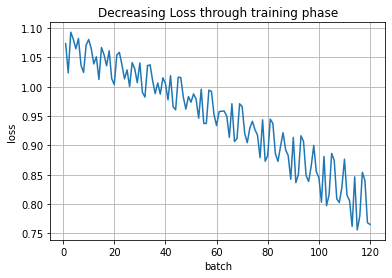

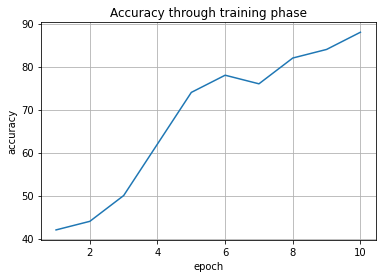

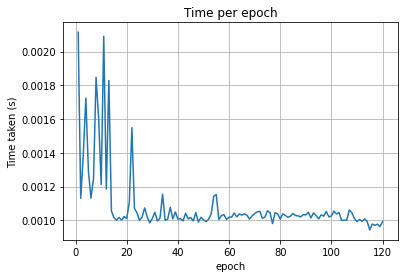

In [41]:
#print(loss_across_epoch)
cnt = np.arange(1, len(loss_across_epoch)+1, 1)

plt.plot( cnt,loss_across_epoch)

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Decreasing Loss through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(accuracy_across_epoch)+1, 1)

plt.plot( cnt,accuracy_across_epoch)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(time_across_epoch)+1, 1)

plt.plot( cnt,time_across_epoch)

plt.xlabel('epoch')
plt.ylabel('Time taken (s)')
plt.title('Time per epoch')
plt.grid(True)
plt.show()

In [50]:
for n in nn_model_neurons:
    model = Net(n)

    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    for epoch in range(1, args.epochs + 1):
        train(args, model, simple_train_loader, optimizer, epoch,False)
        acc_t = test(args, model, simple_test_loader,False)
        
    print('\nTraining with {} neurons: Accuracy: {:.0f}%\n'.format(n,acc_t))
    accuracy_nn_model.append(acc_t)


Training with 16 neurons: Accuracy: 78%


Training with 24 neurons: Accuracy: 70%


Training with 32 neurons: Accuracy: 82%


Training with 48 neurons: Accuracy: 86%


Training with 64 neurons: Accuracy: 88%


Training with 84 neurons: Accuracy: 96%



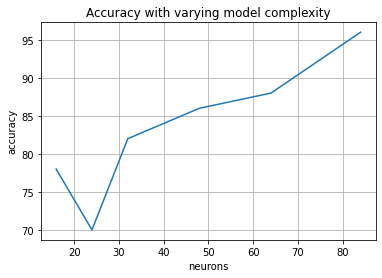

In [52]:
plt.plot( nn_model_neurons,accuracy_nn_model)

plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Accuracy with varying model complexity')
plt.grid(True)
plt.show()

We are getting around 90% accuracy using normal training data.

In [43]:
#Save metadata
with open('wine-time', 'wb') as fp:
    pickle.dump(time_across_epoch, fp)
    
with open('wine-acc', 'wb') as fp:
    pickle.dump(accuracy_across_epoch, fp)
    

In [53]:
with open('wine-comp', 'wb') as fp:
    pickle.dump(accuracy_nn_model, fp)